##### Data exploration on Image dataset
This notebook will explore several data exploration techniques applied to the image dataset in use. These include:
* Total size of the dataset
* Aspect ratio of images
* Image sizes
* Ratio of grayscale to RGB images
* Detection of blurred images

In [193]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image
import sklearn

In [78]:
# import configs
with open('configs.yaml', 'r') as file:
    configs = yaml.safe_load(file)
DATASET_PATH = configs['dataset_path']

In [79]:
# Load dataset

image_data = []
if os.path.exists(DATASET_PATH): 
    try:
        for file in os.listdir(DATASET_PATH):
            image_path = os.path.join(DATASET_PATH, file)
            # Open image and extract properties
            with Image.open(image_path) as img:
                width, height = img.size
                # Append image properties to image_data 
                image_data.append([file, round((os.path.getsize(image_path)/1e6),2), width, height, img.mode])
        # create pd.DataFrame for further evaluation
        image_df = pd.DataFrame(data=image_data,columns=['File_Name','File_Size(MB)','Width','Height','Mode'])
        print(image_df)
    except FileNotFoundError:
        print("Error: Dataset path does not exist.")
else:
    print("Error: Dataset path does not exist.")

        File_Name  File_Size(MB)  Width  Height Mode
0      164911.jpg           0.08    900    1181  RGB
1       16500.jpg           0.10    612     783  RGB
2       60960.jpg           0.06    600     344  RGB
3       10320.jpg           0.05    435     580  RGB
4      145941.jpg           0.02    317     474  RGB
...           ...            ...    ...     ...  ...
11101  151541.jpg           0.02    280     356  RGB
11102   33480.jpg           0.08    467     649  RGB
11103   78210.jpg           0.47   1356    2952    L
11104  128250.jpg           0.02    300     300  RGB
11105  166531.jpg           0.17    600     811  RGB

[11106 rows x 5 columns]


In [80]:
# Total dataset size
print(f'Total number of Images: {len(image_df)}')

Total number of Images: 11106


In [169]:
#  Basic Statistical details
image_df.describe()

,File_Size(MB),Width,Height,Aspect_Ratio
count,11106.000000,11106.000000,11106.000000,11106.000000
mean,0.100658,743.113632,735.070322,1.122945
std,0.180273,513.579267,533.361875,0.474673
min,0.010000,256.000000,256.000000,0.202000
25%,0.030000,480.000000,415.000000,0.739793
50%,0.050000,600.000000,600.000000,0.983065
75%,0.100000,800.000000,849.000000,1.474926
max,3.800000,8000.000000,7780.000000,4.250000


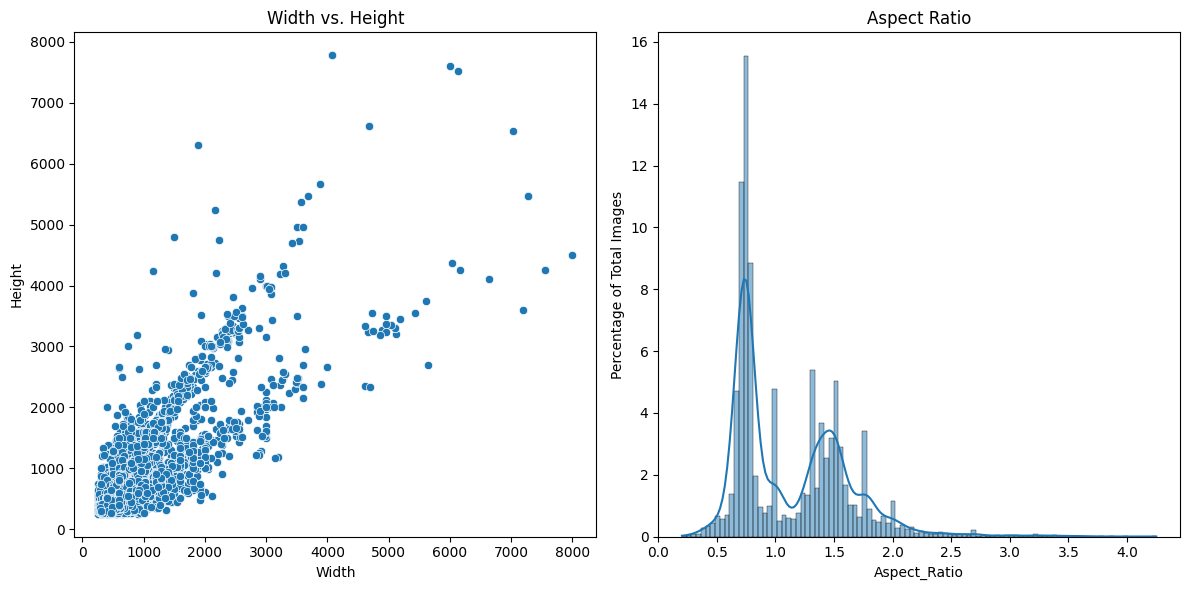

In [164]:
# Dimensions of the image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
image_df['Aspect_Ratio'] = image_df['Width']/image_df['Height']
sns.scatterplot(data=image_df,x='Width',y='Height',ax=ax[0])
ax[0].set_title('Width vs. Height')
sns.histplot(data=image_df,x='Aspect_Ratio',bins=100,stat='percent',kde=True, ax=ax[1])
ax[1].set_title('Aspect Ratio')
ax[1].set_ylabel('Percentage of Total Images')

plt.tight_layout()

Text(0, 0.5, 'Percentage of Total Images')

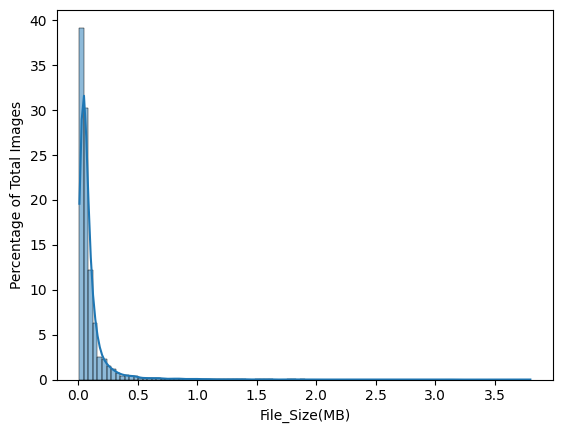

In [87]:
# Image file size
sns.histplot(data=image_df,x='File_Size(MB)',bins=100,stat='percent',kde=True)
plt.ylabel('Percentage of Total Images')

Mode
RGB    11039
L         67
Name: count, dtype: int64


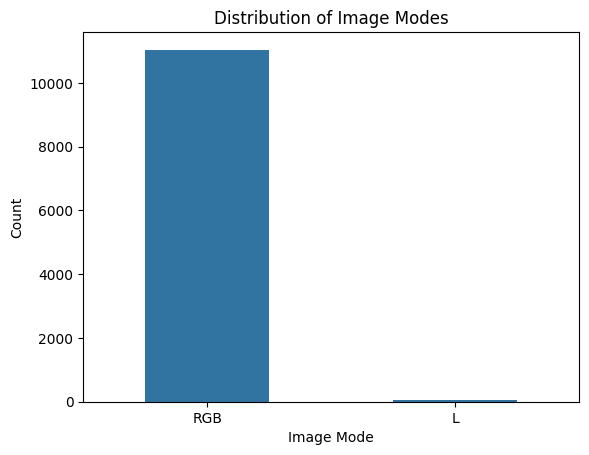

In [121]:
# Image Mode ( RGB or Gray (L))
mode_counts = image_df['Mode'].value_counts()
sns.barplot(x=mode_counts.index, y=mode_counts.values,width=0.5)
plt.title('Distribution of Image Modes')
plt.xlabel('Image Mode')
plt.ylabel('Count')
print(mode_counts)


In [160]:
# Blur Images

def detect_blur(image_path, threshold=20):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    is_blurry = variance < threshold
    return variance, is_blurry

blur_list=[]
laplacian_variance = []
for file in image_df['File_Name']:
    img_path= os.path.join(DATASET_PATH, file)
    variance, is_blurry = detect_blur(img_path)
    laplacian_variance.append(variance)
    if is_blurry:
        blur_list.append('Yes')
    else:
        blur_list.append('No')
       

Blur
No     11091
Yes       15
Name: count, dtype: int64


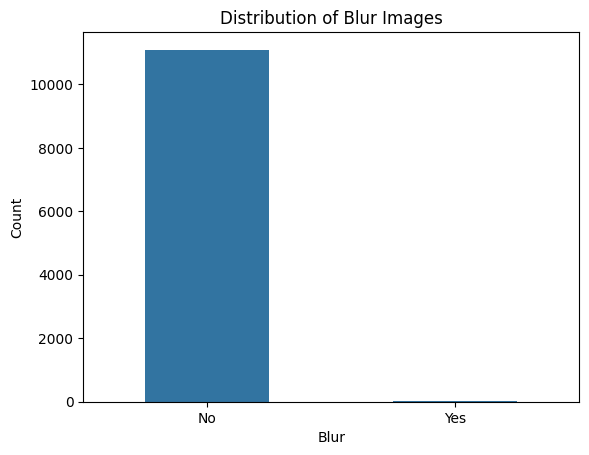

In [178]:
image_df['Blur']= blur_list
blur_counts = image_df['Blur'].value_counts()
sns.barplot(x=blur_counts.index, y=blur_counts.values,width=0.5)
plt.title('Distribution of Blur Images')
plt.xlabel('Blur')
plt.ylabel('Count')
print(blur_counts)

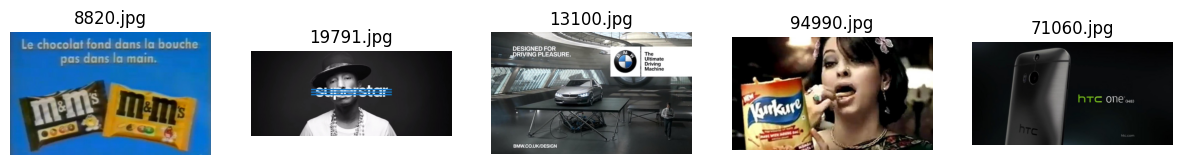

In [184]:
blur_images = [image_df['File_Name'][i] for i in range(len(image_df)) if image_df['Blur'][i]=='Yes']

num_images_to_display = 5
if len(blur_images) < num_images_to_display:    
    num_images_to_display = len(blur_images)
    
import random
random_images = random.sample(blur_images, num_images_to_display)

plt.figure(figsize=(15, 6))
for i, img_path in enumerate(random_images):
    plt.subplot(1, num_images_to_display, i+1)
    image_path = os.path.join(DATASET_PATH, img_path)
   
    with Image.open(image_path) as img:
        plt.imshow(img)

    plt.title(img_path)
    plt.axis('off')
    
#159400.jpg

/home/asmaa/qdrant_test/Text2ImageSearch/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


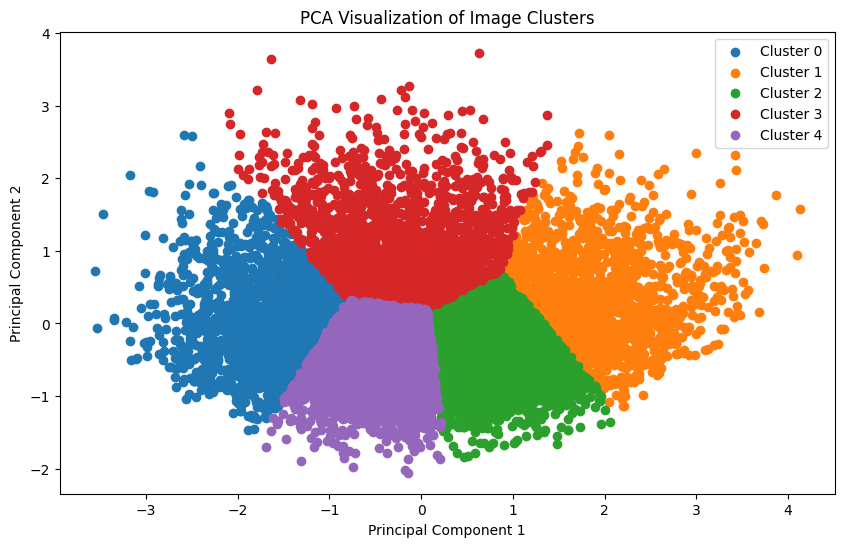

In [207]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.io import imread_collection
from skimage.transform import resize
from skimage.feature import hog
from sklearn.cluster import KMeans

# Function to extract HOG features from images
def extract_features(image_collection, resize_shape=(64, 64)):
    features = []
    for img in image_collection:
        img_resized = resize(img, resize_shape)
        if img.ndim == 3:
            channel_axis = 2
        else:
            channel_axis = None
        hog_features = hog(img_resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2),channel_axis=channel_axis)
        features.append(hog_features)
    return np.array(features)

# Load images from directory
image_files = [os.path.join(DATASET_PATH, file) for file in os.listdir(DATASET_PATH)]
images = imread_collection(image_files)

# Extract HOG features from images
features = extract_features(images)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(features_pca)

# Visualize the clusters
plt.figure(figsize=(10, 6))
for cluster_id in range(5):
    plt.scatter(features_pca[clusters == cluster_id, 0], features_pca[clusters == cluster_id, 1], label=f'Cluster {cluster_id}')
plt.title('PCA Visualization of Image Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [208]:
features

array([[0.34836265, 0.12074667, 0.11850149, ..., 0.07399424, 0.02432698,
        0.0807371 ],
       [0.19242667, 0.0734353 , 0.03654983, ..., 0.        , 0.        ,
        0.02948486],
       [0.10304256, 0.12313495, 0.07330857, ..., 0.05105947, 0.05527235,
        0.20002626],
       ...,
       [0.0239358 , 0.03399423, 0.32254379, ..., 0.        , 0.13875496,
        0.06337109],
       [0.43685154, 0.20180044, 0.18426482, ..., 0.18278182, 0.00856956,
        0.14954523],
       [0.04767621, 0.0184374 , 0.02029171, ..., 0.01989553, 0.03484448,
        0.04752063]])

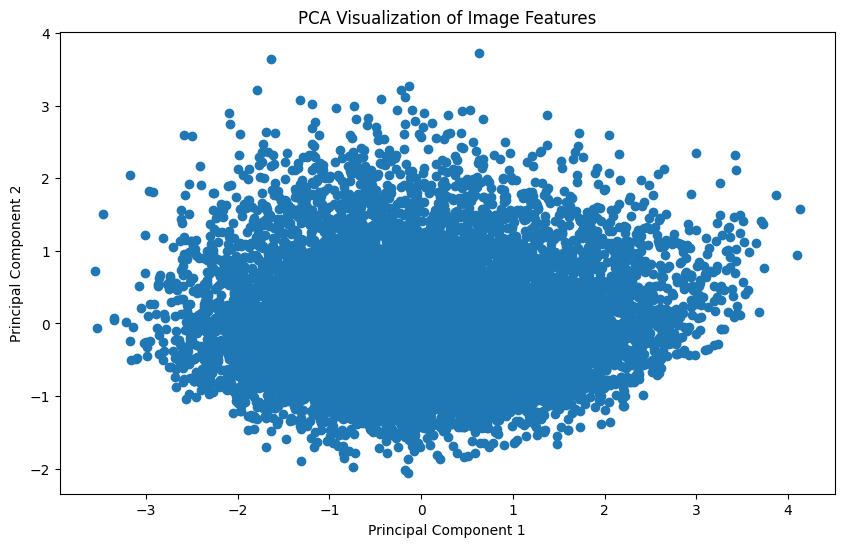

In [222]:
features_pca
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1])
plt.title('PCA Visualization of Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [216]:
clusters

0

/home/asmaa/qdrant_test/Text2ImageSearch/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


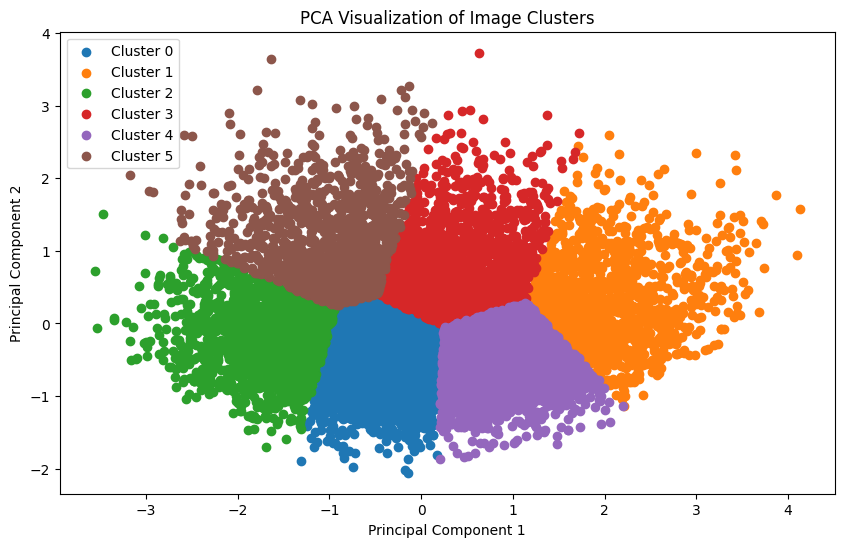

In [221]:
#Apply K-means clustering
kmeans = KMeans(n_clusters=6)
clusters1 = kmeans.fit_predict(features_pca)

# Visualize the clusters
plt.figure(figsize=(10, 6))
for cluster_id in range(6):
    plt.scatter(features_pca[clusters1 == cluster_id, 0], features_pca[clusters1 == cluster_id, 1], label=f'Cluster {cluster_id}')
plt.title('PCA Visualization of Image Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

/home/asmaa/qdrant_test/Text2ImageSearch/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


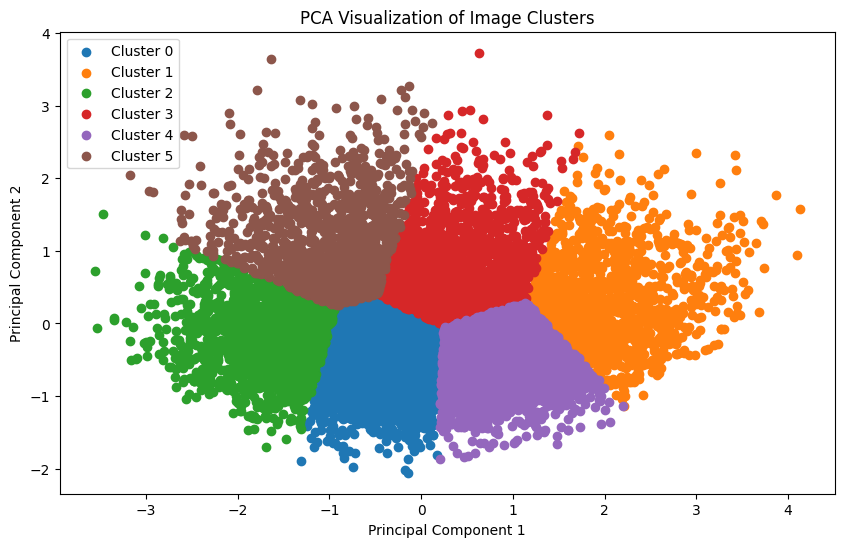

In [ ]:
#Apply K-means clustering
kmeans = KMeans(n_clusters=6)
clusters1 = kmeans.fit_predict(features_pca)

# Visualize the clusters
plt.figure(figsize=(10, 6))
for cluster_id in range(6):
    plt.scatter(features_pca[clusters1 == cluster_id, 0], features_pca[clusters1 == cluster_id, 1], label=f'Cluster {cluster_id}')
plt.title('PCA Visualization of Image Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()